# Projet 9 : Détection de faux billets


Selon l'Office central pour la répression du faux-monnayage à la direction centrale de la police judiciaire (France), 700 000 faux billets circuleraient dans la zone euro, dont 30 à 40 % seraient émis depuis la France.

En 2021, 12 billets contrefaits ont été détectés par million de coupures authentiques en circulation.

Les faux billets que l’on retrouve le plus en circulation sont les coupures de 20 et 50 euros, avec régulièrement des pics constatés avec les billets de 100 euros. 

L'euro est le billet le plus sécurisé au monde, avec une dizaine de signes de sécurité apparents utilisant les meilleures techniques du moment : 
- Filigrane 
- Taille douce (le papier est imprimé par une plaque de cuivre dans laquelle divers motifs sont taillés en creux, ce qui procure au dessin un léger relief) 
- Fil métallique incorporé 
- Vision par transparence (un demi-motif est reproduit sur chaque face et l'image complète n'apparaît que par transparence) ; papier à texture spéciale 
- Microlettres ; encres à couleur changeante ou magnétisées 
- Hologramme (image en trois dimensions réalisée par des faisceaux laser). 

Ces signes sont complétés par des techniques de prévention plus ou moins élaborées, telles que le chiffrage des billets (un billet comporte une lettre, chaque État membre ayant sa propre lettre – u pour la France – suivie de 11 chiffres). Dans une série de billets, le chiffre des unités croît, tandis que celui des dizaines décroît. 

D'autres signes sont tenus secrets.


Il est interdit de le remettre en circulation (article 442-7 du code pénal). Les billets faux doivent être remis à la Banque de France (article L. 162-2 du code monétaire et financier) contre un reçu.

In [1]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

# Représentation graphique:
import matplotlib.pyplot as plt
import seaborn as sns

# Régression lineaire:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression

# Régression logistique:
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score

# K-mean:
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Options globales pour l'output display:
pd.options.display.float_format = "{:.3f}".format

# Importation des données:
Billet_df = pd.read_csv("billets.csv")               

# 1) Informations générales concernant la structure d'un billet

Informations concernant la structure d'un billet : 
- length : la longueur du billet (en mm)
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm)
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm)
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)
- diagonal : la diagonale du billet (en mm)

## Stucture de la table des données

In [2]:
Billet_df.shape

(1500, 7)

Nous avons une tableau avec 1500 lignes et 7 variables.

In [3]:
Billet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
# Nous allons vérifier s'il y a des valeurs manquantes
Billet_df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Dans la colonne "margin_low", 37 variables sont manquantes.

In [5]:
Billet_df.mean()

is_genuine       0.667
diagonal       171.958
height_left    104.030
height_right   103.920
margin_low       4.486
margin_up        3.151
length         112.679
dtype: float64

In [6]:
Billet_df.groupby(by="is_genuine").mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.901,104.190,104.144,5.216,3.350,111.631
True,171.987,103.949,103.809,4.116,3.052,113.202


## Matrice des corrélations

In [7]:
corr_df = Billet_df.corr()
mb=pd.DataFrame(corr_df)
mb.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000,0.133,-0.380,-0.485,-0.783,-0.606,0.849
diagonal,0.133,1.000,0.019,-0.024,-0.112,-0.056,0.098
height_left,-0.380,0.019,1.000,0.242,0.303,0.247,-0.321
height_right,-0.485,-0.024,0.242,1.000,0.391,0.307,-0.402
margin_low,-0.783,-0.112,0.303,0.391,1.000,0.432,-0.667
margin_up,-0.606,-0.056,0.247,0.307,0.432,1.000,-0.521
length,0.849,0.098,-0.321,-0.402,-0.667,-0.521,1.000


<AxesSubplot:>

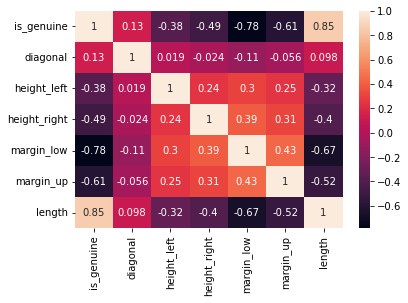

In [8]:
# heatmap de corrélations entre les différentes variables
sns.heatmap(Billet_df.corr(), annot=True)

Text(0.5, 1.0, 'Taux des vrais et faux billets')

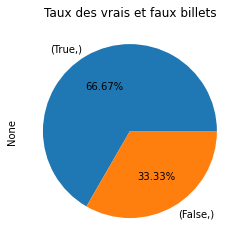

In [9]:
# Diagramme en fonction des faux billets et des vrais billets
Billet_df[['is_genuine']].value_counts().plot.pie(autopct = lambda x: str(round(x, 2)) + '%')
plt.title('Taux des vrais et faux billets')

In [10]:
Billet_df.groupby(by="is_genuine").mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.901,104.190,104.144,5.216,3.350,111.631
True,171.987,103.949,103.809,4.116,3.052,113.202


# 2) Traitement des valeurs manquantes

Utilisation du modèle de régression linéaire multivariables pour traiter nos valeurs manquantes
Nous allons séparer le dataframe original en 2:

- Un dataframe sans valeur manquantes que nous utiliserons pour notre régression liniéaire
- Un dataframe avec uniquement les valeurs manquantes pour appliquer notre modèle

In [11]:
# Séparation des données manquantes :
Reg_Lin_Train_df = Billet_df.dropna()
Reg_Lin_Test_df = Billet_df[Billet_df.isnull().any(axis=1)]

# Création de X_train et Y_train:
x_train = Reg_Lin_Train_df.drop("margin_low", axis=1)
y_train = Reg_Lin_Train_df["margin_low"]

# Régression linéaire:
reg_lin = LinearRegression()
model_reg_lin = reg_lin.fit(x_train, y_train)

# Prédictions:
x_train = Reg_Lin_Train_df[["is_genuine","diagonal","height_left","height_right", "margin_up", "length"]]
Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)

C:\Users\acmla\AppData\Local\Temp/ipykernel_23752/4075991522.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)


In [12]:
print("Intercept:", model_reg_lin.intercept_)
print("Coéfficients:", model_reg_lin.coef_)

Intercept: 2.866822892054086
Coéfficients: [-1.14059676 -0.0130159   0.02829069  0.02674982 -0.21284432 -0.00388299]


In [13]:
# Instanciation:
reg_linb = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = Billet_df)

# Calculs:
res_lin = reg_linb.fit()
print(res_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 09 Nov 2022   Prob (F-statistic):          2.60e-202
Time:                        21:27:49   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

In [14]:
print("R2: ", res_lin.rsquared)

R2:  0.4773366973063955


Ce coefficient varie entre 0 et 1, soit entre un pouvoir de prédiction faible et un pouvoir de prédiction fort.

Le coefficient de détermination (R², soit le carré du coefficient de corrélation linéaire r) est un indicateur qui permet de juger la qualité d’une régression linéaire simple. 

Il mesure l’adéquation entre le modèle et les données observées ou encore à quel point l’équation de régression est adaptée pour décrire la distribution des points.

##### 1) Le test de Jarque-Bera (normalité):

C'est un test d'hypothèse qui cherche à déterminer si des données suivent une loi normale : 
Comme pour chaque test d'hypothèse, il faut poser une hypothèse nulle à valider :
- H0: les données suivent une loi normale.
- H1: les données ne suivent pas une loi normale.

Si la probabilité est inférieure à 5%, on rejette l'hypothèse nulle de la distribution normale. 
Si la probabilité est supérieure à 5% , on accepte l'hypothèse nulle de la distribution normale.


##### 2) Le test Omnibus (normalité):
L'une des hypothèses d'OLS est que les erreurs sont normalement distribuées. 
Un test omnibus est effectué afin de vérifier cela. 
Ho = Les erreurs sont normalement distribuées. 
Prob(Omnibus) est supposé être proche de 1 pour satisfaire l'hypothèse OLS. 
Dans ce cas, Prob(Omnibus) est de 0, ce qui implique que l'hypothèse OLS n'est pas satisfaite. 
Pour cette raison, les coefficients estimés à partir de celui-ci ne sont pas les meilleurs estimateurs linéaires sans biais.

Pour vérifier la normalité, on va donc mettre en place un histogramme.

##### 3) Le test de Durbin-Watson (autocorrélation) :
C'est un test statistique destiné à tester l'autocorrélation des résidus dans un modèle de régression linéaire.
Le test de Durbin-Watson cherche à vérifier la significativité du coefficient ρ dans la formule :

- H0 : Il y a non auto-corrélation  
- H1 : Il y a auto-corrélation

La statistique DW prend ses valeurs entre 0 (auto-corrélation linéaire positive) et 4 (auto-corrélation linéaire négative). L'hypothèse nulle est retenue si la statistique a une valeur proche de 2 (pas d'auto-corrélation linéaire).

##### 4) Kurtosis : 

Le coefficient d'aplatissement (K, kurtosis en anglais) évalue la dispersion des valeurs "extrêmes" par référence à la loi normale. 
Le coefficient d’aplatissement (en américain, kurtosis) est un coefficient particulièrement difficile à interpréter. On sait que, dans le cas d’une loi normale, il est égal à 3.
Une distribution normale est mésokurtique

# 3) Tests

## Une régression complète ne se limite pas au calcul des estimations. 

## En effet, il est indispensable de valider le modèle estimé, c’est-à-dire de vérifier son adéquation aux données analysées. 

## Pour cela, on utilise les résidus.

- Normalité de la distribution des résidus 
- Homocédasticité 
- Autocorrélation 
- Multicollinéarité 

### Moyenne

- Les résidus sont des approximations des erreurs inconnues e(i).
- Une des propriétés est que la série des résidus possède une moyenne est nulle

In [15]:
# La moyenne des residus est nulle car largement inférieure à 0:
Reg_Lin_Train_df["residus"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]
Reg_Lin_Train_df["residus"].mean()

C:\Users\acmla\AppData\Local\Temp/ipykernel_23752/2946626269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["residus"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]


-5.463845370677462e-18

### Normalité 

##### Test de la normalité des résidus
Si les résidus Ei sont normalement distribués alors les erreurs εi le sont aussi.

On peut tester si les résidus suivent une loi normale avec :
*  Un histogramme.
*  Un test de normalité (par ex. Shapiro-Wilk).
*  Un graphique de probabilité normale des Ei

Si le modèle est idéalement bon, alors les écarts que l’on constate entre les valeurs prédites et les valeurs observées (les résidus donc) sont entièrement imputables à des erreurs de mesure. De ce fait, les résidus doivent posséder les propriétés classiques d’une distribution normale : courbe « en cloche », symétrique autour de la valeur prédite, avec un aplatissement régulier des extrémités. En cas de violation de cette assomption, les tests de signification risquent d’être biaisés.

On peut par exemple obtenir la « droite de Henry » qui met en relation les valeurs observées des résidus (abscisse) avec des valeurs z construites sous l’hypothèse que la distribution des résidus est normale. Idéalement, on doit avoir l’identité, c'est-à-dire que tous les points du graphe doivent être situés sur la droite en rouge

#### Test de Shapiro-Wilk :
Les tests de normalité impliquent l'hypothèse nulle que la variable ayant généré l'échantillon suit une distribution normale. 

Ainsi, une p-value faible indique un risque faible de se tromper en concluant que les données sont non-normales. En d'autres termes, si p-value < risque alpha, les données s'écartent significativement de la normalité.

C:\Users\acmla\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


La p-value est de 3.9857722331535204e-05


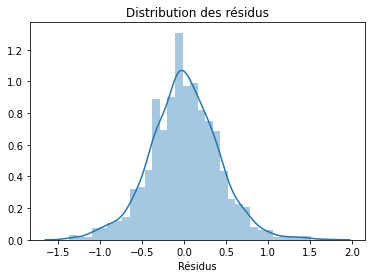

In [16]:
sns.distplot(Reg_Lin_Train_df["residus"])

# Normalite:
print("La p-value est de", normal_ad(Reg_Lin_Train_df["residus"])[1])
plt.xlabel("Résidus")
plt.ylabel("")
plt.title("Distribution des résidus")
plt.show()

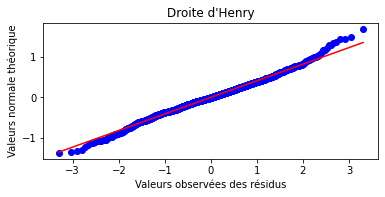

In [17]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(Reg_Lin_Train_df["residus"], plot=ax, fit=True)
plt.xlabel("Valeurs observées des résidus")
plt.ylabel("Valeurs normale théorique")
plt.title("Droite d'Henry")
plt.show()

En principe, tous les points du graphe doivent être situés sur la droite en rouge. 

Ici nous pouvons observe que le résultat est assez satisfaisant bien qu'il existe un très léger biais au niveau des valeurs extrêmes.

### L'homoscédasticité  :

C'est une caractéristique d'un modèle de régression linéaire qui implique que la variance des erreurs est constante dans le temps.

Ce terme, qui s'oppose à l'hétéroscédasticité, est utilisé pour désigner la propriété de certains modèles de régression linéaire dans lesquels les erreurs d'estimation sont constantes tout au long des observations. Une variance constante nous permet d'avoir des modèles plus fiables. De plus, si une variance, en plus d'être constante, est également plus petite, cela se traduira par une prédiction de modèle plus fiable.

L'homoscédasticité est une propriété souhaitable des erreurs dans un modèle de régression simple.

{'Test Statistic': 109.86015196890001, 'p-value': 2.0828244987712717e-14, 'F-Statistic': 5.853731207814999, 'F-Test p-value': 4.974865092167631e-15}


Text(0.5, 1.0, 'Homoscédasticité')

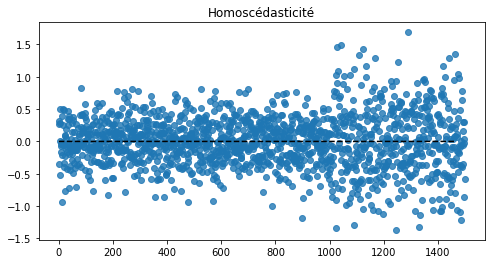

In [18]:
white_test = het_white(res_lin.resid, res_lin.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))


plt.subplots(figsize=(8, 4))
plt.scatter(x=Reg_Lin_Train_df.index, y=Reg_Lin_Train_df["residus"], alpha=0.8)
plt.plot(np.repeat(0, len(Reg_Lin_Train_df.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

La répartition semble aléatoire sur le graphique. 

H0 : Il y a homoscédasticité. Les résidus sont dispersés aléatoirement, la variance d'un individu à un autre est constante 

H1: Il y a hétéroscédasticité. 

La p-value (5%) est inférieure au seuil, on ne peut pas rejeter l'hypothèse nulle d'homoscédasticité. L'hypothèse d'homoscédasticité de notre régression linéaire est vérifiée.

### La multicolinéarité 

La multicolinéarité est la forte corrélation entre plus de deux variables explicatives.

In [19]:
variables = res_lin.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686293,
 1.1382605736082447,
 1.2301145155560367,
 1.4044037781843608,
 1.5769501453665835]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.
L’absence de multicolinéarité parfaite est une des conditions requises pour pouvoir estimer un modèle linéaire et, par extension, un modèle linéaire généralisé

## Application du modèle sur les données

In [20]:
# Application du modèle sur les données 
x_test = Reg_Lin_Test_df[["is_genuine","diagonal","height_left","height_right", "margin_up","length"]]
Reg_Lin_Test_df["margin_low"] = reg_lin.predict(x_test)

# Concaténation:
reg_lin_result = [Reg_Lin_Test_df, Reg_Lin_Train_df]
Billet_df = pd.concat(reg_lin_result)
Billet_df = Billet_df.drop(["margin_low_pred", "residus"], axis=1)
Billet_df.info()
Billet_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 72 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


C:\Users\acmla\AppData\Local\Temp/ipykernel_23752/3575104208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Test_df["margin_low"] = reg_lin.predict(x_test)


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000,1500.000,1500.000,1500.000,1500.000,1500.000
mean,171.958,104.030,103.920,4.483,3.151,112.679
std,0.305,0.299,0.326,0.660,0.232,0.873
min,171.040,103.140,102.820,2.980,2.270,109.490
25%,171.750,103.820,103.710,4.027,2.990,112.030
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.310,113.340
max,173.010,104.880,104.950,6.900,3.910,114.440


In [21]:
# Vérification des données après la régression linéaire
Billet_df.info()
Billet_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 72 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000,1500.000,1500.000,1500.000,1500.000,1500.000
mean,171.958,104.030,103.920,4.483,3.151,112.679
std,0.305,0.299,0.326,0.660,0.232,0.873
min,171.040,103.140,102.820,2.980,2.270,109.490
25%,171.750,103.820,103.710,4.027,2.990,112.030
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.310,113.340
max,173.010,104.880,104.950,6.900,3.910,114.440


In [22]:
# Vérification de l'absence de valeurs nulles
Billet_df.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

# 5) Matrice de confusion et K-means

La matrice de confusion est en quelque sorte un résumé des résultats de prédiction pour un problème particulier de classification. Elle compare les données réelles pour une variable cible à celles prédites par un modèle. Les prédictions justes et fausses sont révélées et réparties par classe, ce qui permet de les comparer avec des valeurs définies.

Également connue sous le nom de tableau de contingence, la matrice de confusion permet d'évaluer les performances d'un modèle de classification. Elle montre donc à quel point un certain modèle peut être confus lorsqu'il fait des prédictions. Dans sa forme la plus simple, il s'agit d'une matrice 2X2.

La matrice de confusion permet de connaître d'une part les différentes erreurs commises par un algorithme de prédiction, mais plus important encore, de connaître les différents types d'erreurs commis.

Les 4 cas possibles lors d’une prédiction binaire sont :

- Vrai négatif (True Negative) :
La prédiction est négative et c’est la réalité.

- Vrai positif (True Positive) :
La prédiction est positive et c’est la réalité.

- Faux positif (False positive), erreur de 1ère espèce :
La prédiction est positive mais ce n’est pas la réalité.

- Faux négatif (False negative), erreur de 2ème espèce :
La prédiction est négative mais ce n’est pas la réalité.

C:\Users\acmla\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


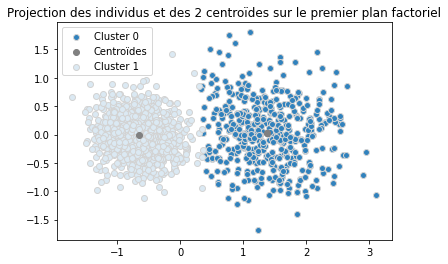

is_genuine  False  True
row_0                  
0             481     2
1              19   998


In [23]:
# Nombre de clusters (vrai - faux):
n_clust = 2

# Clustering par K-means:
km = KMeans(n_clusters=n_clust,random_state=1994)
x_km = km.fit_transform(Billet_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

# Ajout d'une colonne contenant le cluster attribué:
clusters_km = km.labels_
#billet_final["cluster_km"] = km.labels_
#billet_final["cluster_km"] = billet_final["cluster_km"].apply(str)

centroids_km = km.cluster_centers_

# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components=2).fit(Billet_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=2).fit_transform(Billet_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)

# Graphique:
for couleur,k in zip(["#3182bd","#dbe9f3"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des individus et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()

# Matrice de confusion:
km_matrix = pd.crosstab(clusters_km,Billet_df["is_genuine"])
print(km_matrix)

Text(0.5, 1.0, 'Matrice de confusion K-means\n')

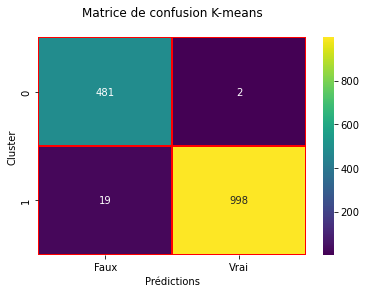

In [24]:
# Matrice de confusion:
sns.heatmap(km_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("viridis", as_cmap=True),
            linecolor = "red",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n")

- Parmis les 500 faux billets, 19 ont été détectés comme étant vrais

- Parmis les 1000 vrais billets, 2 ont été détectés comme étant faux

# 6) KNN

L’algorithme K-NN (K-nearest neighbors) est une méthode d’apprentissage supervisé. Il peut être utilisé aussi bien pour la régression que pour la classification. 

Son fonctionnement peut être assimilé à l’analogie suivante “dis moi qui sont tes voisins, je te dirais qui tu es…”.

Pour pouvoir effectuer une prédiction, K-NN se base sur le jeu de données pour produire un résultat.


* Étape 1 :  Sélectionnez le nombre K de voisins
* Étape 2 :  Calculez la distance
* Étape 3 :  Prenez les K voisins les plus proches selon la distance calculée.
* Étape 4 :  Parmi ces K voisins, comptez le nombre de points  appartenant à chaque catégorie.
* Étape 5 : Attribuez le nouveau point à la catégorie la plus présente parmis ces K voisins.
* Étape 6 : Notre modèle est prêt :

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [26]:
x2train, x2test, y2train, y2test = train_test_split(Billet_df.drop(["is_genuine"],axis=1), Billet_df[["is_genuine"]], test_size=0.2)

In [27]:
from sklearn.metrics import accuracy_score,silhouette_score
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(x2train)
X_train_std = std_scale.transform(x2train)
X_test_std = std_scale.transform(x2test)

In [28]:
X_train_std.shape

(1200, 6)

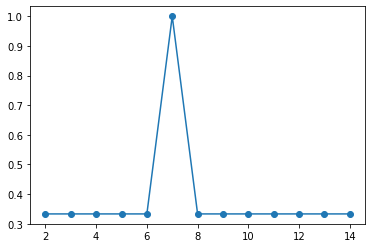

In [29]:
from sklearn import neighbors,model_selection
# Optimisation du score sur les données test
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    #knn.fit(x2train, y2train)
    errors.append(100*(1 - knn.fit(X_train_std,y2train.values.ravel()).score(X_test_std,y2test.values.ravel())))
plt.plot(range(2,15), errors, 'o-')
plt.show()

In [30]:
from sklearn import model_selection
# Fixer les valeurs des hyperparamètres à tester
param_grid =  {'n_neighbors': range(2,16) }
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Création classifieur kNN 
clf1 = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimisation
clf1.fit(X_train_std, y2train.values.ravel())

# Affichage des hyperparamètres optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf1.best_params_)

# Affichage des performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf1.cv_results_['mean_test_score'], # score moyen
        clf1.cv_results_['std_test_score'],  # écart-type du score
        clf1.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 8}
Résultats de la validation croisée :
accuracy = 0.978 (+/-0.011) for {'n_neighbors': 2}
accuracy = 0.985 (+/-0.021) for {'n_neighbors': 3}
accuracy = 0.987 (+/-0.017) for {'n_neighbors': 4}
accuracy = 0.990 (+/-0.012) for {'n_neighbors': 5}
accuracy = 0.991 (+/-0.013) for {'n_neighbors': 6}
accuracy = 0.991 (+/-0.013) for {'n_neighbors': 7}
accuracy = 0.992 (+/-0.012) for {'n_neighbors': 8}
accuracy = 0.991 (+/-0.013) for {'n_neighbors': 9}
accuracy = 0.990 (+/-0.012) for {'n_neighbors': 10}
accuracy = 0.991 (+/-0.013) for {'n_neighbors': 11}
accuracy = 0.990 (+/-0.012) for {'n_neighbors': 12}
accuracy = 0.990 (+/-0.012) for {'n_neighbors': 13}
accuracy = 0.991 (+/-0.013) for {'n_neighbors': 14}
accuracy = 0.990 (+/-0.012) for {'n_neighbors': 15}


In [31]:
x2test.shape

(300, 6)

In [32]:
from sklearn.metrics import confusion_matrix
# Affichage des : vrais négatifs, vrais positifs, faux négatifs, faux positifs
tn0, fp0, fn0, tp0 = confusion_matrix(y2test,clf1.predict(X_test_std)).ravel()
tn0, fp0, fn0, tp0
print('Vrais négatifs :',tn0,"\n"'Vrais positifs :',tp0,"\n"'Faux négatifs :',fn0,"\n"'Faux positifs :',fp0)

Vrais négatifs : 93 
Vrais positifs : 206 
Faux négatifs : 0 
Faux positifs : 1


# 7) Régression logistique

La régression logistique est une technique statistique qui a pour objectif, à partir d’un fichier d’observations, de produire un modèle permettant de prédire les valeurs prises par une variable catégorielle, le plus souvent binaire, à partir d’une série de variables explicatives continues et/ou binaires.

In [33]:
# y (authenticité): 
y_billet = Billet_df.loc[:, Billet_df.columns == "is_genuine"]
print(y_billet.value_counts())                                  

# X (le reste):
X_billet = Billet_df.loc[:, Billet_df.columns != "is_genuine"]
X_billet = sm.tools.add_constant(X_billet)                      
print(X_billet.head())

is_genuine
True          1000
False          500
dtype: int64
     const  diagonal  height_left  height_right  margin_low  margin_up  length
72   1.000   171.940      103.890       103.450       4.065      3.250 112.790
99   1.000   171.930      104.070       104.180       4.112      3.140 113.080
151  1.000   172.070      103.800       104.380       4.134      3.020 112.930
197  1.000   171.450      103.660       103.800       3.994      3.620 113.270
241  1.000   171.830      104.140       104.060       4.140      3.020 112.360


C:\Users\acmla\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
# Régression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Calculs:
res_log = reg_log.fit()

# Résultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.026349
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.9586
Time:                        21:27:53   Log-Likelihood:                -39.524
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -230.4143    249.954     -0.922      0.357    -720.316     259.487
diagonal         0.256

Variables x non-significatives au seuil alpha 5 % (si on prend alpha 1 %, on enlèvera height_right en plus), on recommence la régression sans ces variables (diagonal, height_left, height_right).

In [35]:
# On ne garde que les variables significatives a alpha = 5% dans X_Billet:
X_billet = Billet_df[["height_right","margin_low", "margin_up", "length"]]
X_billet = sm.add_constant(X_billet)

# On recommence la régression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Modèle:
model_reg_log = reg_log.fit()

# Résultats:
print(model_reg_log.summary2())


Optimization terminated successfully.
         Current function value: 0.026815
         Iterations 13
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.958   
Dependent Variable:   is_genuine       AIC:              90.4453 
Date:                 2022-11-09 21:27 BIC:              117.0114
No. Observations:     1500             Log-Likelihood:   -40.223 
Df Model:             4                LL-Null:          -954.77 
Df Residuals:         1495             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       13.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -285.3339 139.1600 -2.0504 0.0403 -558.0825 -12.5852
height_right   -3.3223   1.1166 -2.9752 0.0029   -5.5109  -1.1337

C:\Users\acmla\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [36]:
# Application du modèle sur les données :
Billet_df["proba"] = model_reg_log.predict(X_billet)
Billet_df["y_pred"] = (model_reg_log.predict(X_billet) >= 0.5).astype(int)
Billet_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
72,True,171.940,103.890,103.450,4.065,3.250,112.790,0.998,1
99,True,171.930,104.070,104.180,4.112,3.140,113.080,0.998,1
151,True,172.070,103.800,104.380,4.134,3.020,112.930,0.997,1
197,True,171.450,103.660,103.800,3.994,3.620,113.270,0.989,1
241,True,171.830,104.140,104.060,4.140,3.020,112.360,0.965,1


[[492.   8.]
 [  3. 997.]]


Text(0.5, 1.0, 'Matrice de confusion de la régression logistique\n')

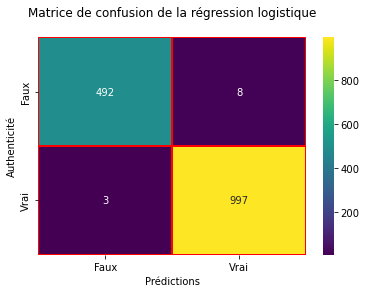

In [37]:
# Matrice de confusion
conf_matrix_reg_log = model_reg_log.pred_table()
prct = (conf_matrix_reg_log)
print(prct)

sns.heatmap(conf_matrix_reg_log,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("viridis", as_cmap=True),
            linecolor = "red",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique\n")

- Parmis les 500 faux billets, 8 ont été détectés comme étant vrais

- Parmis les 1000 vrais billets, 3 ont été détectés comme étant faux

# 8) Test avec billets_production fournis

In [38]:
# Test avec la régression logistique sur les données test fournies (billets_production) :

Billet_test_df = pd.read_csv("billets_production.csv")


X_test = Billet_test_df[["height_right","margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)
Billet_test_df["proba"] = model_reg_log.predict(X_test)
Billet_test_df["y_pred"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
print(Billet_test_df[["id","proba","y_pred"]])


print("\nIndetification des billets:")
for i, k in zip(Billet_test_df["y_pred"],Billet_test_df["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")

    id  proba  y_pred
0  A_1  0.000       0
1  A_2  0.000       0
2  A_3  0.000       0
3  A_4  0.996       1
4  A_5  1.000       1

Indetification des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


C:\Users\acmla\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# 9) Test avec un second fichier

In [39]:
# Test avec la régression logistique sur les données test fournies (billets_production_test) :

testbillet = pd.read_csv("billets_production_test.csv")


X_test = testbillet[["height_right","margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)
testbillet["proba"] = model_reg_log.predict(X_test)
testbillet["y_pred"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
print(testbillet[["id","proba","y_pred"]])


print("\nIndetification des billets:")
for i, k in zip(testbillet["y_pred"],testbillet["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")

    id  proba  y_pred
0  A_1  0.000       0
1  A_2  0.000       0
2  A_3  0.000       0
3  A_4  0.996       1
4  A_5  1.000       1

Indetification des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


C:\Users\acmla\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
